<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Heat2D_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# A heat solver

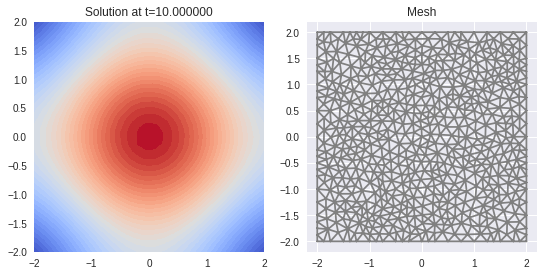

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


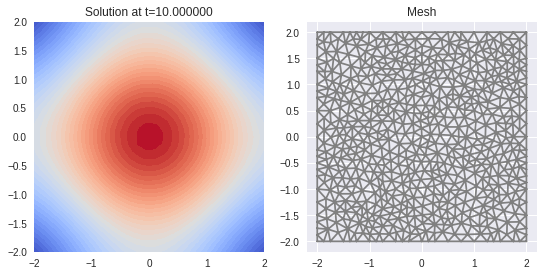

In [12]:
def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Solution at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); # plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

solver = KrylovSolver("gmres")
solver.parameters["relative_tolerance"] = 5e-6
solver.parameters["maximum_iterations"] = 1000
solver.parameters["monitor_convergence"] = True


# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 20;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define finite element function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Finite element functions
v = TestFunction(V); 
u = Function(V);

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

# Time parameters
theta = 1.0 # Implicit Euler
k = 0.1; # Time step
t, T = 0., 10.; # Start and end time

# Exact solution
k_coeff = 0.1
ue = Expression("exp(-(x[0]*x[0]+x[1]*x[1])/(4*a*t))/(4*pi*a*t)", a=k_coeff, t=0, domain=mesh, degree=degree+1) 
ue.t = k/10.;
u0 = ue;

bc = DirichletBC(V, ue, boundary)

# Inititalize time stepping
pl, ax = None, None; 
stepcounter = 0; 
timer0 = time.clock()

# Time-stepping loop
while t < T: 
    # Time scheme
    um = theta*u + (1.0-theta)*u0 
    
    # Weak form of the heat equation in residual form
    r = (u - u0)/k*v*dx + k_coeff*inner(grad(um), grad(v))*dx 
    
    # Solve the Heat equation (one timestep)
    solve(r==0, u, bc)  
    
    # Plot all quantities (see implementation above)
    pl, ax=plot_compact(u, t, stepcounter, V, pl, ax)
    
    # Shift to next timestep
    t += k; u0 = project(u, V); 
    ue.t = t;
    stepcounter += 1 